# iminuit tutorial

Welcome to the **iminuit tutorial**. You will learn basic usage of iminuit and how to approach standard fitting problems with iminuit. 

iminuit is a Python frontend to the *Minuit* library in C++, an integrated software that combines a local minimizer (called *Migrad*) and two error calculators (called *Hesse* and the *Minos*). You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, iminuit minimizer is like other local minimizers, like those in scipy.optimize.

In addition, iminuit has the ability to compute **uncertainty estimates** for model parameters. iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. The two ways of computing uncertainty estimates, *Hesse* and the *Minos*, have different advantages and disadvantages.

iminuit is the successor of pyminuit. If you used pyminuit before, you will find iminuit very familiar. An important feature of iminuit (and pyminuit) is that it uses introspection to detect the parameter names of your function. This is very convenient, especially when you work interactively in a Jupyter notebook. It also provides special output routines for Jupyter notebooks to pretty print the fit results, as you will see below.

In [1]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

## Quick start

In this first section, we look at a simple case where line should be fitted to scattered $(x, y)$ data. A line has two parameters $(\alpha, \beta)$. We go through the full fit, showing all basic steps to get you started quickly. In the following sections we will revisit the steps in more detail.

<ErrorbarContainer object of 3 artists>

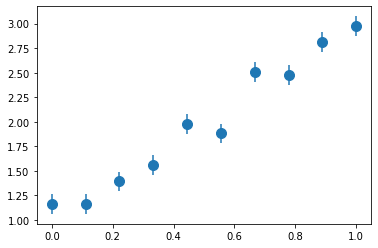

In [2]:
# our line model, unicode parameter names are supported :) 
def line(x, α, β):
    return α + x * β


# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o")

**Pro-tip**: if you want to use Greek letters, consider installing an additional Greek keyboard layout for easier typing.

To recover the parameters α and β of the line model from this data, we need to a minimize a suitable cost function. The cost function must be twice differentiable and have a minimum at the optimal parameters. We use the method of least-squares here, whose cost function computes the sum of squared residuals between the model and the data. The task of iminuit is to find the minimum of that function. Let's do it:

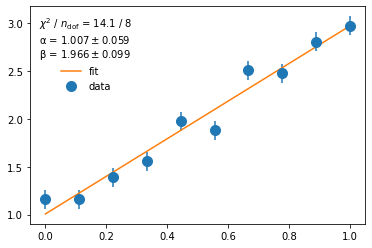

In [3]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",    
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info))

And that is already it for a basic fit. Easy, right?

In the following, we dive into the details step by step; how the Minuit object is initialized, how to run the algorithms, and how to get the results.

iminuit was designed to make it easy to fit functions like `least_squares(a, b)`, where the parameters are individual arguments of the function. There is an alternative function signature that Minuit supports, which is more convenient when you work a lot with numpy. Here, the parameters are passed as a numpy array. The two kinds of function definitions have each pros and cons. We will first dive how to work with functions of the first kind and come back to the second kind later.

## Initialize the Minuit object

To minimize a function, one has to create an instance of the Minuit class and pass the function and a starting value for each parameter. This does not start the minimization yet, this will come later.

The `Minuit` object uses introspection to get the number and names of the function parameters automatically, so that they can be initialized with keywords.

In [4]:
m = Minuit(least_squares, α=0, β=0)

If we forget a parameter or mistype, Minuit will raise an error. 

In [5]:
try:
    Minuit(least_squares)
except:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-5-2975dab14c6b>", line 2, in <module>
    Minuit(least_squares)
  File "/home/hdembinski/Code/iminuit/src/iminuit/_minuit.py", line 466, in __init__
    raise RuntimeError(
RuntimeError: starting value(s) are required for α β


In [6]:
try:
    Minuit(least_squares, a=0, b=0)
except:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-6-a5081bb50cd5>", line 2, in <module>
    Minuit(least_squares, a=0, b=0)
  File "/home/hdembinski/Code/iminuit/src/iminuit/_minuit.py", line 485, in __init__
    self._init_state = _make_init_state(self._pos2var, args, kwds)
  File "/home/hdembinski/Code/iminuit/src/iminuit/_minuit.py", line 1408, in _make_init_state
    raise RuntimeError(
RuntimeError: a is not one of the parameters [α β]


### Initial parameter values

Minuit's main algorithm Migrad is a local minimizer. It searches for a local minimum by a doing a mix of Newton steps and gradient-descents from a starting point. If your function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, iminuit will converge to it faster if you start in the proximity of the minimum.

You can set the starting point using the parameter names as keywords, `<name> = <value>`.

In [7]:
Minuit(least_squares, α=5, β=5)  # pass starting values for α and β

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.00,0.05,,,,,
1,β,5.00,0.05,,,,,


Alternatively, the starting values can also be passed as positional arguments.

In [8]:
Minuit(least_squares, 5, 5)  # another way of passing starting values for α and β

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.00,0.05,,,,,
1,β,5.00,0.05,,,,,


You can also use iminuit with functions that accept numpy arrays. This has pros and cons.

**Pros**
- Easy to change number of fitted parameters
- Sometimes simpler function body that's easier to read
- Technically this is more efficient, but this is hardly going to be noticable

**Cons**
- iminuit cannot figure out names for each parameter

To demonstrate, use a version of the line model which accepts the parameters as a numpy array.

In [9]:
def line_np(x, par):
    return np.polyval(par, x)  # for len(par) == 2, this is a line

Calling `line_np` with more or less arguments is easy and will use a polynomial of the corresponding order to predict the behavior of the data.

The builtin cost functions support such a model. For it to be detected properly, you need to pass the starting values in form a single sequence of numbers. 

In [10]:
least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

Minuit(least_squares_np, (5, 5))  # pass starting values as a sequence

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


Any sequence will work for initialization, you can also pass a list or a numpy array here. iminuit uses the length of the sequence to detect how many parameters the model has. By default, the parameters are named automatically `x0` to `xN`. One can override this with the keyword `name`, passing a sequence of parameter names.

In [11]:
Minuit(least_squares_np, (5, 5), name=("a", "b"))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


Since `least_squares_np` works for parameter arrays of any length, one can easily change the number of fitted parameters.

In [12]:
# fit a forth order polynomial
Minuit(least_squares_np, (5, 5, 5, 5))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,
2,x2,5.00,0.05,,,,,
3,x3,5.00,0.05,,,,,


It is often useful to try different orders of a polynomial model. If the order is too small, the polynomial will not follow the data. If it is too large, it will overfit the data and pick up random fluctuations and not the underlying trend. One can figure out the right order by experimenting or using an algorithm like cross-validation.

### Inspecting current parameters

You can check the current parameter values and settings with the method `Minuit.params` at any time. It returns a special list of `Param` objects which pretty-prints in Jupyter and in the terminal.

In [13]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,,,
1,β,0.0,0.1,,,,,



This produces a nice table with numbers rounded according to the rules of the *Particle Data Group*. The table will be updated once you run the actual minimization. To look at the initital conditions later, use `Minuit.init_params`. We will come back to the meaning of *Hesse Error* and *Minos Error* later.

`Minuit.params` returns a tuple-like container of `Param` objects, which are data objects with attributes that one can query. Use `repr()` to get a detailed representation of the data object.

In [14]:
for p in m.params:
    print(repr(p), "\n")

Param(number=0, name='α', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None) 

Param(number=1, name='β', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None) 



### Parameters with limits

iminuit allows you to set parameter limits. Often a parameter is limited mathematically or physically to a certain range. For example, if your function contains `sqrt(x)`, then $x$ must be non-negative, $x \ge 0$. You can set upper-, lower-, or two-sided limits for each parameter individually with the `limits` property.

- lower limit: use `Minuit.limits[<name>] = (<value>, None)` or `(<value>, float("infinity"))`
- upper limit: use `Minuit.limits[<name>] = (None, <value>)` or `(-float("infinity"), <value>)`
- two-sided limit: use `Minuit.limits[<name>] = (<min_value>, <max_value>)`
- remove limits: use `Minuit.limits[<name>] = None` or  `(-float("infinity"), float("infinity")`

You can also set limits for several parameters at once with a sequence. To impose the limits $α \ge 0$ and $0 \le β \le 10$ in our example, we use:

In [15]:
m.limits = [(0, None), (0, 10)]
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,0,,
1,β,0.0,0.1,,,0,10,


### Fixing and releasing parameters

Sometimes you have a parameter which you want to set to a fixed value temporarily. Perhaps you have a guess for its value, and you want to see how the other parameters adapt when this parameter is fixed to that value.

Or you have a complex function with many parameters that do not all affect the function at the same scale. Then you can manually help the minimizer to find the minimum faster by first fixing the less important parameters to initial guesses and fit only the important parameters. Once the minimum is found under these conditions, you can release the fixed parameters and optimize all parameters together. Minuit remembers the last state of the minimization and starts from there. The minimization time roughly scales with the square of the number of parameters. Iterated minimization over subspaces of the parameters can reduce that time.

To fix an individual parameter, you use the keyword `Minuit.fixed[<name>] = True`. In our example, we fix $a$, like so:

In [16]:
m.fixed["α"] = True
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,0,,yes
1,β,0.0,0.1,,,0,10,


In [17]:
# migrad will not vary a, only b
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 307.8                      │              Nfcn = 41               │
│ EDM = 2.53e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 1 │ β    │   3.40    │   0.05    │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │       0       0 │
│ β │       0 0.00284 │
└───┴─────────────────┘

In [18]:
# now we release a and fix b and minimize again, can also use parameter index
m.fixed[0] = False
m.fixed[1] = True
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 222.8                      │              Nfcn = 77               │
│ EDM = 5.24e-09 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   0.292   │   0.032   │            │            │    0    │         │       │
│ 1 │ β    │   3.40    │   0.05    │            │            │    0    │   10    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     α     β │
├───┼─────────────┤
│ α │ 0.001     0 │
│ β │     0     0 │
└───┴─────────────┘

We could iterate this and would slowly approach the minimum, but that's silly; instead we release both parameters and run again. The array-like views support broadcasting, which is useful to releasing all parameters at once.

In [19]:
# use broadcasting to unfix all parameters
m.fixed = False
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │              Nfcn = 127              │
│ EDM = 5.79e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │            │            │    0    │         │       │
│ 1 │ β    │   1.97    │   0.10    │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        α        β │
├───┼───────────────────┤
│ α │  0.00345 -0.00491 │
│ β │ -0.00491  0.00982 │
└───┴───────────────────┘

### Varying starting points for minimization

It is sometimes useful to change the values of some fixed parameters by hand and fit the others or to restart the fit from another starting point. For example, if the cost function has several minima, changing the starting value can be used to find the other minimum.


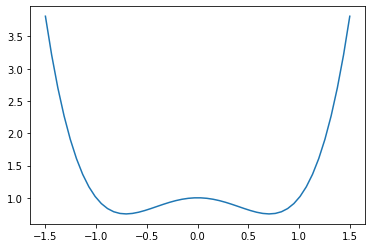

In [20]:
def cost_function_with_two_minima(x):
    return x ** 4 - x ** 2 + 1

# we come back to the meaning of errordef in the next section
cost_function_with_two_minima.errordef = Minuit.LEAST_SQUARES 

x = np.linspace(-1.5, 1.5)
plt.plot(x, cost_function_with_two_minima(x));

In [21]:
# starting at -0.1 gives the left minimum
m = Minuit(cost_function_with_two_minima, x=-0.1)
m.migrad()
print("starting value -0.1, minimum at", m.values["x"])

# changing the starting value to 0.1 gives the right minimum
m.values["x"] = 0.1  # m.values[0] = 0.1 also works
m.migrad()
print("starting value +0.1, minimum at", m.values["x"])

starting value -0.1, minimum at -0.7085906080341975
starting value +0.1, minimum at 0.708796091342642


### Advanced: Simplex and Scan minimizers 

iminuit also offers two other minimizers which are less powerful than Migrad, but may be useful in special cases.

#### Simplex

The Nelder-Mead method (aka SIMPLEX) is well described on [Wikipedia](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method). It is a gradient-free minimization method that usually converges more slowly, but may be more robust. For some problems it can help to start the minimization with SIMPLEX and then finish with MIGRAD. Since the default stopping criterion for SIMPLEX is much more lax than MIGRAD, either running MIGRAD after SIMPLEX or reducing the tolerance with `Minuit.tol` is strongly recommended.

In [22]:
Minuit(cost_function_with_two_minima, x=10).simplex()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.7501                     │              Nfcn = 23               │
│ EDM = 0.0176 (Goal: 0.1)         │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Let's run MIGRAD to finish the minimization.

In [23]:
Minuit(cost_function_with_two_minima, x=10).simplex().migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.75                       │              Nfcn = 36               │
│ EDM = 1.12e-08 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   x │
├───┼─────┤
│ x │ 0.5 │
└───┴─────┘

This combination uses slightly fewer function evaluations than just running MIGRAD alone.

In [24]:
Minuit(cost_function_with_two_minima, x=10).migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.75                       │              Nfcn = 38               │
│ EDM = 4.38e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     x │
├───┼───────┤
│ x │ 0.497 │
└───┴───────┘

#### Scan

Scan is a last resort. It does a N-dimensional grid scan over the parameter space. The number of function evaluations scale like $n^k$, where $k$ is the number of parameters and $n$ the number of steps along one dimension. Using scan for high-dimensional problems is unfeasible, but it can be useful in low-dimensional problems and when all but a few parameters are fixed. The scan needs bounds, which are best set with `Minuit.limits`. The number of scan points is set with the `ncall` keyword.

In [25]:
m = Minuit(cost_function_with_two_minima, x=10)
m.limits = (-10, 10)
m.scan(ncall=10)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.29                       │              Nfcn = 15               │
│ EDM = 0.417 (Goal: 0.1)          │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -1.1    │    0.4    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

The scan brought us in the vicinity of the minimum. One should always run MIGRAD or SIMPLEX after a SCAN.

In [26]:
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.75                       │              Nfcn = 37               │
│ EDM = 1.33e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -0.7    │    0.7    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     x │
├───┼───────┤
│ x │ 0.499 │
└───┴───────┘

### Advanced: Errordef

If you do not use one of the cost functions from the `iminuit.cost` module, you need to pass an additional parameter to Minuit. Let's make a custom least-squares function and try to run Migrad on it.

In [27]:
# a simple least-squares cost function looks like this...
def custom_least_squares(a, b):
    ym = line(data_x, a, b)
    z = (data_y - ym) / data_yerr ** 2
    return np.sum(z ** 2)


Minuit(custom_least_squares, a=5, b=5).migrad()

<ipython-input-27-1d0345eceb0a>:8: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  Minuit(custom_least_squares, a=5, b=5).migrad()


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1406                       │              Nfcn = 34               │
│ EDM = 3.27e-20 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.007   │   0.006   │            │            │         │         │       │
│ 1 │ b    │   1.966   │   0.010   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  3.45e-05 -4.91e-05 │
│ b │ -4.91e-05  9.82e-05 │
└───┴─────────────────────┘

Minuit now warns about using its default value for the `errordef` parameter, which may not be appropriate. Setting this is not needed for the cost functions in `iminuit.cost`, but it is needed for custom cost functions.

The `errordef` parameter is used to compute correct uncertainties. If you don't care about uncertainty estimates (but why are you using Minuit then?), you can ignore the warning. In statistical problems, there are two kinds of cost functions to minimize, the *negative log-likelihood* and the *least-squares* function. Each has a corresponding value for `errordef`:
 - `0.5` or the constant `Minuit.LIKELIHOOD` for negative log-likelihood functions 
 - `1` or the constant `Minuit.LEAST_SQUARES` for least-squares functions 

The origin of these numbers is not too complicated, but cannot be explained briefly. If you are curious, have a look into the tutorial "Error computation with HESSE and MINOS", which explains in depth how uncertainties are computed and where this value comes from.


For our custom cost function, we need to set `m.errordef=1` or equivalent and more readable `m.errordef=Minuit.LEAST_SQUARES`, because it is of the least-squares type. If we do that, the warning disappears.

In [28]:
m = Minuit(custom_least_squares, a=5, b=5)
m.errordef = Minuit.LEAST_SQUARES
m.migrad()  # no warning

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1406                       │              Nfcn = 34               │
│ EDM = 3.27e-20 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.007   │   0.006   │            │            │         │         │       │
│ 1 │ b    │   1.966   │   0.010   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  3.45e-05 -4.91e-05 │
│ b │ -4.91e-05  9.82e-05 │
└───┴─────────────────────┘

An even better way is to add an attribute called `errordef` to the cost function. If such an attribute is present, Minuit uses it. That's how the builtin cost functions allow to skip setting it.

In [29]:
custom_least_squares.errordef = Minuit.LEAST_SQUARES

Minuit(custom_least_squares, a=5, b=5).migrad()  # no warning

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1406                       │              Nfcn = 34               │
│ EDM = 3.27e-20 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.007   │   0.006   │            │            │         │         │       │
│ 1 │ b    │   1.966   │   0.010   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  3.45e-05 -4.91e-05 │
│ b │ -4.91e-05  9.82e-05 │
└───┴─────────────────────┘

### Advanced: Initial step sizes

Minuit uses a gradient-descent method to find the minimum and the gradient is computed numerically using finite differences. The initial step size is used to compute the first gradient. A good step size is small compared to the curvature of the function, but large compared to numerical resolution. Using a good step size can slightly accelerate the convergence, but Minuit is not very sensitive to the choice. If you don't provide a value, iminuit will guess a step size based on a heuristic.

You can set initital step sizes with the `errors` property, `Minuit.errors[<name>] = <step size>`. Using an appropriate step size is important when you have you a parameter which has physical bounds. Varying the initial parameter value by the step size may not create a situation where the parameter goes outside of its bounds. For example, a parameter $x$ with $x > 0$ and initital value $0.1$ may not have a step size of $0.2$.

In our example, we could use an initital step size of $\Delta α = 0.1$ and $\Delta β = 0.2$. Setting both can be done conveniently by assigning a sequence:

In [30]:
m = Minuit(least_squares, α=5, β=5)
m.errors = (0.1, 0.2)  # assigning sequences works
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.0,0.1,,,,,
1,β,5.0,0.2,,,,,


Broadcasting is also supported.

In [31]:
m.errors = 0.3  # broadcasting
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.0,0.3,,,,,
1,β,5.0,0.3,,,,,


### Advanced: Override parameter name detection

iminuit tries hard to detect the parameter names correctly. It works for a large variety of cases. For example, if you pass a functor instead of a function, it will use the arguments of the `__call__` method, automatically skipping `self`. It even tries to parse the docstring if all else fails.

You can check which parameter names iminuit finds for your function with the `describe` function.

In [32]:
from iminuit import describe


def foo(x, y, z):
    pass


assert describe(foo) == ("x", "y", "z")


class Foo:
    def __call__(self, a, b):
        pass


assert describe(Foo()) == ("a", "b")

Sometimes parameter names cannot be determined. For example, in case of functions which accept a variable number of arguments.

In [33]:
def func_varargs(*args):  # function with variable number of arguments
    return np.sum((np.array(args) - 1) ** 2)

func_varargs.errordef = Minuit.LEAST_SQUARES

assert describe(func_varargs) == ()

`describe` cannot detect the number and names of the parameters in this case and returns `None`. If you work with functions that accept a variable number of arguments a lot, it is better to use a cost function which accepts a parameter array (this is explained in the next section).

When iminuit cannot detect the arguments, but you know how many arguments there are, or if you simply want to override the names found by iminuit, you can do that with the keyword `name`, like so:

In [34]:
Minuit(func_varargs, name=("a", "b"), a=1, b=2).migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.867e-19                  │              Nfcn = 24               │
│ EDM = 2.87e-19 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │     1     │     1     │            │            │         │         │       │
│ 1 │ b    │     1     │     1     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │         1 -5.55e-17 │
│ b │ -5.55e-17         1 │
└───┴─────────────────────┘

### Alternative interface: iminuit.minimize

Those familiar with scipy may find the `minimize` function useful. It exactly mimics the function interface of `scipy.optimize.minimize`, but uses `Minuit` for the actual minimization. The `scipy` package must be installed to use it.

In [35]:
from iminuit import minimize  # has same interface as scipy.optimize.minimize

minimize(least_squares_np, (5, 5))

      fun: 14.064905067721458
 hess_inv: [[ 0.00490909 -0.00245455]
 [-0.00245455  0.00172727]]
  message: 'Optimization terminated successfully.'
   minuit: <FMin edm=1.743960428579217e-22 edm_goal=0.0001 errordef=0.5 fval=14.064905067721458 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=32 ngrad=0>
(Param(number=0, name='x0', value=1.9660364327572295, error=0.07006490527278346, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.007267694541101, error=0.041560470871550084, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None))
[[ 0.00490909 -0.00245455]
 [-0.00245455  0.00172727

This interface is handy if you want to be able to switch between iminuit and `scipy.optimize.minimize` but we recommend the standard interface instead. It is an advantage of Minuit that you can interact and manually steer the minimization process. This is not possible with a functional interface like `minimize`.

## Investigating the fit status

Calling `Minuit.migrad()` runs the actual minimization with the Migrad algorithm. Migrad essentially tries a Newton-step and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. So far so ordinary. The clever bits in Migrad are how various pathological cases are handled.

Let's look again at the output of `Minuit.migrad()`.

In [36]:
m = Minuit(least_squares, α=5, β=5)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │              Nfcn = 30               │
│ EDM = 1.83e-21 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        α        β │
├───┼───────────────────┤
│ α │  0.00345 -0.00491 │
│ β │ -0.00491  0.00982 │
└───┴───────────────────┘

The `Minuit.migrad` method returns the Minuit instance so that one can chain method calls. The instance also pretty prints the latest state of the minimization.

The first block in this output is showing information about the function minimum. This is good for a quick check:

- All blocks should be green.
- Purple means something bad. 
- Yellow may be bad or not. Be careful.

Let's see how it looks when the function is bad.

In [37]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
m_bad.errordef = 1  # avoid the errordef warning
m_bad.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Coming back to our previous good example, the info about the function minimum can be directly accessed with `Minuit.fmin`:

In [38]:
m.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │              Nfcn = 30               │
│ EDM = 1.83e-21 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [39]:
# print(repr(...)) to see a detailed representation of the data object
print(repr(m.fmin))

<FMin edm=1.8292728930869197e-21 edm_goal=0.0002 errordef=1.0 fval=14.064905067721456 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=30 ngrad=0>


The most important one here is `is_valid`. If this is false, the fit did not converge and the result is useless. Since this is so often queried, a shortcut is provided with `Minuit.valid`.

If the fit fails, there is usually a numerical or logical issue.

- The fit function is not analytical everywhere in the parameter space or does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point or maximum). Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`. A non-analytical function is one with a discrete step, for example.
- Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method  `Minuit.migrad`. Note that `nfcn` can be slightly larger than `ncall`, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen.

Migrad detects convergence by a small `edm` value, the *estimated distance to minimum*. This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function (something that Migrad computes as part of its algorithm). If the fit did not converge, `is_above_max_edm` is true.

If you are interested in parameter uncertainties, you should make sure that:

- `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are true.
- `has_made_posdef_covar` and `hesse_failed` are false.

The second object of interest after the fit is the parameter list, which can be directly accessed with `Minuit.params`.

In [40]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,,,,,
1,β,1.97,0.10,,,,,


In [41]:
for p in m.params:
    print(repr(p))

Param(number=0, name='α', value=1.0072676945407022, error=0.05877538157386399, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)
Param(number=1, name='β', value=1.9660364327566007, error=0.09908673933103641, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)


`m.params` is a tuple-like container of `Param` data objects which contain information about the fitted parameters. Important fields are:
- `number`: parameter index.
- `name`: parameter name.
- `value`: value of the parameter at the minimum.
- `error`: uncertainty estimate for the parameter value.

Whether the uncertainty estimate is accurate depends on the correct mathematical modeling of your fitting problem and using the right `errordef` value for Minuit. What do we mean by correct mathematical modelling? If you look into the function `simple_least_squares(a, b)`, you see that each squared residuals is divided by the expected variance of the residual. This is necessary to get accurate uncertainty estimates for the parameters.

Sometimes the expected variance of the residual is not well known. If the function to minimize is a least-squares function, there is a simple test to check whether the residual variances are ok. One should look at the function value at the minimum, here given by `fmin.fval`, and divide it by the difference of the number of residuals and the number of fitted parameters, which can be conveniently queried with the attribute `nfit`. This is called reduced chi2.

In [42]:
m.fval / (len(data_y) - m.nfit)  # reduced chi2

1.758113133465182

This value should be around 1. The more data points one has, the closer. If the value is much larger than 1, then the data variance is underestimated or the model does not describe the data. If the value is much smaller than 1, then the data variance is overestimated (perhaps because of positive correlations between the fluctuations of the data values).

The last block shows the covariance matrix, this is useful to check for large correlations which are usually a sign of trouble.

In [43]:
m.covariance

,α,β
α,0.00345,-0.00491 (-0.843)
β,-0.00491 (-0.843),0.00982


We will discuss this matrix in more detail in the next section.

##  Parameter uncertainties, covariances, and confidence intervals

You saw how to get the uncertainty of each individual parameter and how to access the full covariance matrix of all parameters together, which includes the correlations. Correlations are essential additional information if you want to work with parameter uncertainties seriously.

Minuit offers two ways to compute the parameter uncertainties, Hesse and Minos. Both have pros and cons.

### Hesse for covariance and correlation matrices

The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. The Hesse matrix is symmetric by construction. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It often is already a good approximation even for finite statistic. These errors obtained from this method are sometimes called *parabolic errors*, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

Pros:
- (Comparably) fast computation.
- Provides covariance matrix for error propagation.

Cons:
- May not have good coverage probability when sample size is small

The Migrad algorithm computes an approximation of the Hesse matrix automatically during minimization. When the default strategy is used, Minuit does a check whether this approximation is sufficiently accurate and if not, it computes the Hesse matrix automatically.

All this happens inside C++ Minuit and is a bit intransparent, so to be on the safe side, we recommend to call `Minuit.hesse` explicitly after the minimization, if exact errors are important.

In [44]:
# let's mess up the current errors a bit so that hesse has something to do
m.errors = (0.16, 0.2)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.16,,,,,
1,β,1.97,0.20,,,,,


In [45]:
m.hesse().params # note the change in "Hesse Error"

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,,,,,
1,β,1.97,0.10,,,,,


#### Covariance and correlation Matrix

To see the covariance matrix of the parameters, you do:

In [46]:
m.covariance

,α,β
α,0.00345,-0.00491 (-0.843)
β,-0.00491 (-0.843),0.00982


The paramaters $a$ and $b$ are stronly anti-correlated, the numerical value of the correlation is shown in parentheses. The correlation is also highlighed by the blue color of the off-diagonal elements.

In [47]:
print(repr(m.covariance))  # use print(repr(...) to skip pretty printing

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


To get the correlation matrix, use:

In [48]:
m.covariance.correlation()  # returns a newly created correlation matrix

,α,β
α,1,-0.843
β,-0.843,1


Nonzero correlation is not necessarily a bad thing, but if you have freedom in redefining the parameters of the fit function, it is good to chose parameters which are not strongly correlated.

Minuit cannot accurately minimise the function if two parameters are (almost) perfectly (anti-)correlated. It also means that one of two parameters is superfluous, it doesn't add new information. You should rethink the fit function in this case and try to remove one of the parameters from the fit.

Both matrices are subclasses of numpy.ndarray, so you can use them everywhere you would use a numpy array. In addition, these matrices support value access via parameter names:

In [49]:
m.covariance["α", "β"]

-0.004909090880254523

### Minos for non-parabolic minima

Minuit has another algorithm to compute uncertainties: Minos. It implements the so-called profile likelihood method, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of `errordef`. The contour defines a confidence region that covers the true parameter point with a certain probability. The probability is exactly known in the limit of infinitely large data samples, but approximate for the finite case. Please consult a textbook about statistics about the mathematical details or look at the tutorial "Error computation with HESSE and MINOS".

Pros:
- Produces pretty confidence regions in 2D (or higher) for scientific plots

Cons:
- Computationally expensive
- Asymmetric errors are difficult to error-propagate

Minos is not automatically called during minimization, it needs to be called explicitly afterwards, like so:

In [50]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │              Nfcn = 73               │
│ EDM = 1.83e-21 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           α           │           β           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬───────────────────┐
│   │        α        β │
├───┼───────────────────┤
│ α │  0.00345 -0.00491 │
│ β │ -0.00491  0.00982 │
└───┴───────────────────┘

By now you are probably used to see green colors, which indicate that Minos ran successful. Be careful when these are red instead, Minos can fail. The fields in the new Minos table mean the following:
- Valid: Whether Minos considers the scan result valid.
- At Limit: True if Minos hit a parameter limit before the finishing the contour, which would be bad.
- Max FCN: True if Minos reached the maximum number of allowed calls before finishing the contour, also bad.
- New Min: True if Minos discovered a deeper local minimum in the neighborhood of the current one. Not necessarily bad, but should not happen.

The errors computed by Minos are now also shown in the parameter list.

In [51]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,-0.06,0.06,,,
1,β,1.97,0.10,-0.10,0.10,,,


If the absolute values of the Minos errors are very close to the Hesse Error, the function is well approximated by a hyperparabola around the minimum. You can use this as a check instead of explicitly plotting the function around the minimum (for which we provide tools, see below).

### Coverage probability of intervals constructed with Hesse and Minos algorithms

In applications, it is important to construct confidence regions with a well-known coverage probability. As previously mentioned, the coverage probability of the intervals constructed from the uncertainties reported by Hesse and Minos are not necessarily the standard 68 %.

Whether Hesse or Minos produce an interval with a coverage probability closer to the desired 68 % in finite samples depends on the case. There are theoretical results which suggest that Hesse may be slightly better, but we also found special cases where Minos intervals performed better.

Some sources claim that Minos gives better coverage when the cost function is not parabolic around the minimum; that is not generally true, in fact Hesse intervals may have better coverage.

As a rule-of-thumb, use Hesse as the default and try both algorithms if accurate coverage probability matters.

## Quick access to fit results

You get the main fit results with properties and methods from the `Minuit` object. We used several of them already. Here is a summary:

In [52]:
print(m.values)  # array-like view of the parameter values

<ValueView α=1.0072676945407022 β=1.9660364327566007>


In [53]:
# access values by name or index
print("by name ", m.values["α"])
print("by index", m.values[0])

by name  1.0072676945407022
by index 1.0072676945407022


In [54]:
# iterate over values
for key, value in zip(m.parameters, m.values):
    print(f"{key} = {value}")

α = 1.0072676945407022
β = 1.9660364327566007


In [55]:
# slicing works
print(m.values[:1])

[1.0072676945407022]


In [56]:
print(m.errors)  # array-like view of symmetric uncertainties

<ErrorView α=0.05877538122335944 β=0.09908673861229153>


`Minuit.errors` supports the same access as `Minuit.values`.

In [57]:
print(m.params) # parameter info (using str(m.params))

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [58]:
print(repr(m.params)) # parameter info (using repr(m.params))

(Param(number=0, name='α', value=1.0072676945407022, error=0.05877538122335944, merror=(-0.0587753813643082, 0.05877538136474316), is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='β', value=1.9660364327566007, error=0.09908673861229153, merror=(-0.09908673886103248, 0.09908673886171207), is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None))


In [59]:
# asymmetric uncertainties (using str(m.merrors))
print(m.merrors)

┌──────────┬───────────────────────┬───────────────────────┐
│          │           α           │           β           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘


In [60]:
# asymmetric uncertainties (using repr(m.merrors))
print(repr(m.merrors))

<MErrors
  <MError number=0 name='α' lower=-0.0587753813643082 upper=0.05877538136474316 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=12 min=1.0072676945407022>,
  <MError number=1 name='β' lower=-0.09908673886103248 upper=0.09908673886171207 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=12 min=1.9660364327566007>
>


In [61]:
print(m.covariance)  # covariance matrix computed by Hesse (using str(m.covariance))

┌───┬───────────────────┐
│   │        α        β │
├───┼───────────────────┤
│ α │  0.00345 -0.00491 │
│ β │ -0.00491  0.00982 │
└───┴───────────────────┘


In [62]:
print(repr(m.covariance))  # covariance matrix computed by Hesse (using repr(m.covariance))

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


As already mentioned, you can play around with iminuit by assigning new values to `m.values` and `m.errors` and then run `m.migrad()` again. The values will be used as a starting point.

## Plotting

iminuit comes with buildin methods to draw the confidence regions around the minimum, like so:

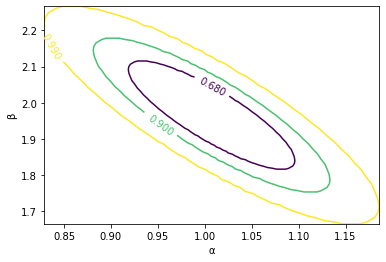

In [63]:
# draw three contours with 68%, 90%, 99% confidence level
m.draw_mncontour("α", "β", cl=(0.68, 0.9, 0.99))

Asymptotically (in large samples), the `cl` is equal to the probability that the region contains the true value. In finate samples, this is usually only approximately so.

In [64]:
# get individual contours to plot them yourself
ctr_xy = m.mncontour("α", "β", cl=0.68, size=10)
print(ctr_xy)

[[0.91854084 2.09212197]
 [0.93860627 2.01263553]
 [0.97400646 1.9386927 ]
 [1.019001   1.86959111]
 [1.08205798 1.81645587]
 [1.09599455 1.8399509 ]
 [1.07592912 1.91943734]
 [1.04052893 1.99338016]
 [0.99553439 2.06248175]
 [0.93247741 2.115617  ]]


If you need to inspect the cost function around the minimum because MINUIT warns you about some issues, you can quickly scan it with a call to `Minuit.draw_profile`.

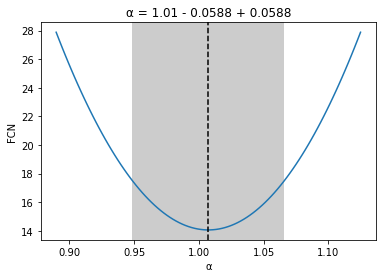

In [65]:
m.draw_profile("α");

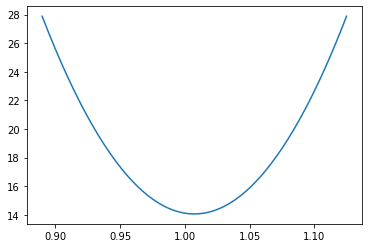

In [66]:
# or use this to plot the result of the scan yourself
a, fa = m.profile("α")
plt.plot(a, fa);

Alternativel, you can use `mnprofile` to do a full profile likelihood scan. This mimics what MINOS does to compute confidence intervals. If you have trouble with MINOS, running this may help to inspect the issue.

This is computationally expensive, since the scan runs MIGRAD for each point on the profile.

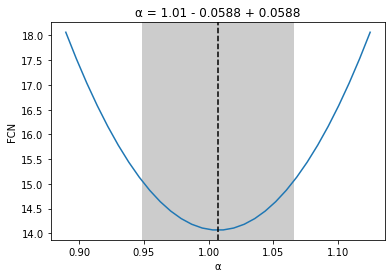

In [67]:
m.draw_mnprofile("α");

Finally, you can also look at the 2D contours of the cost function around the minimum. Note that these are just contours of the fit function, not confidence regions. The latter you can only get from `mncontour`.

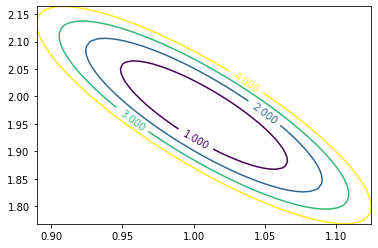

In [68]:
x, y, z = m.contour("α", "β", subtract_min=True)
cs = plt.contour(x, y, z, (1, 2, 3, 4))  # these are not sigmas, just the contour values
plt.clabel(cs);

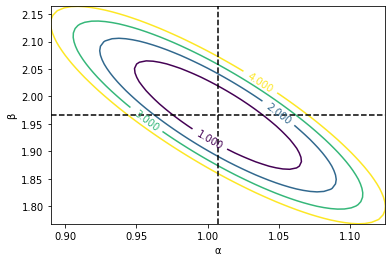

In [69]:
# or use this function for a quick look
m.draw_contour("α", "β");